# Exploratory Data Analysis (EDA)

Author:  David Yang 
Date:    14 July 2017

As a first step of the project, run the following python code snippets to explore univariate and joint distributions of all potential predictor variables and their relationship to the outcome variable: target_commits (#commits made in the month after the year during which data on all other variables were collected). Based on the exploration, we make decision on how to clean the data, handle missing values, choose transforms, and derive new features.   

In [55]:
# Load in the python packages and specify interface parameters  
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 25

In [66]:
# Read the train_data files into Pandas DataFrames
train_data_file = 'train_data.tsv'
column_names = ['index','huid', 'x1', 'x2', 'x3', 'x4', 'x5', 'days_since_commit_comment', 'total_commits', 
                'total_inline_pr_comments', 'days_since_inline_pr_comment', 'total_issue_comments', 
                'days_since_issue_comment', 'total_issues', 'issue_titles', 'days_since_issue', 'total_prs', 
                'pr_titles', 'days_since_pr', 'total_pushes', 'days_since_push', 'target_commits']
train_df = pd.read_csv(train_data_file, sep='\t', skiprows = 1, index_col = 0,  names = column_names)
train_df.head(3)

,huid,x1,x2,x3,x4,x5,days_since_commit_comment,total_commits,total_inline_pr_comments,days_since_inline_pr_comment,total_issue_comments,days_since_issue_comment,total_issues,issue_titles,days_since_issue,total_prs,pr_titles,days_since_pr,total_pushes,days_since_push,target_commits
index,,,,,,,,,,,,,,,,,,,,,
1,7744,4,104,151,189,8,253.0,2003,190,329.0,969,361.0,13,"[Change how documentation is built, New Change...",330.0,489,"[Don't create welcome pages without webroots, ...",361.0,985,361.0,55
2,959,1,7,0,4,0,NaN,711,31,353.0,78,352.0,1,[PHP Warning when converting],231.0,61,"[Profile api, Fix Phone Number Order, Email te...",344.0,549,344.0,15
3,6920,4,11,6,3,0,NaN,80,43,205.0,54,315.0,14,[Web connectivity test contains null in blocki...,261.0,12,"[Ui/redesigned, Result view, App v0.1.0 , Info...",256.0,149,350.0,65


The task description document suggests that there are 22 variables defined in "data_overview.pdf". They match the number of columns in the training data - train_data.tsv, but we see that the values of the first several columns do not match the meaning of the corresponding variables.  For example, the first column should be Line Record, instead of "huid". The third varibale "is_org_member" is boolean (with value 1 or 0), but we cannot find columns that only contain 1s and 0s. "user_age_days" also finds no column to correspond. 

As a tentative solution, let me use ('index', 'huid', 'x1', 'x2', 'x3', 'x4', 'x5') to mark the first 7 columns. All the rest columns have clear alignment with the variable names given in the document.  

In [67]:
# Lists of different types of variables that will be used later for analyses. 
NUMERICAL_COLUMNS    = [f for f in train_df.columns if train_df.dtypes[f] != 'object']; 
NUMERICAL_COLUMNS.remove('huid') # exclude 'huid' from consideration 
NUMERICAL_PREDICTORS = list(NUMERICAL_COLUMNS) # list of numerical variables as predictors in regression analysis
NUMERICAL_PREDICTORS.remove('target_commits')
TEXT_PREDICTORS      = ['issue_titles', 'pr_titles']
OUTCOME_VARIABLE     = ['target_commits']
DAYS_PREDICTORS      = [x for x in train_df.columns.values.tolist() if x.startswith("days")]
NONDAYS_PREDICTORS   = [x for x in NUMERICAL_PREDICTORS if x not in DAYS_PREDICTORS]       

### 1. Check for Missingness

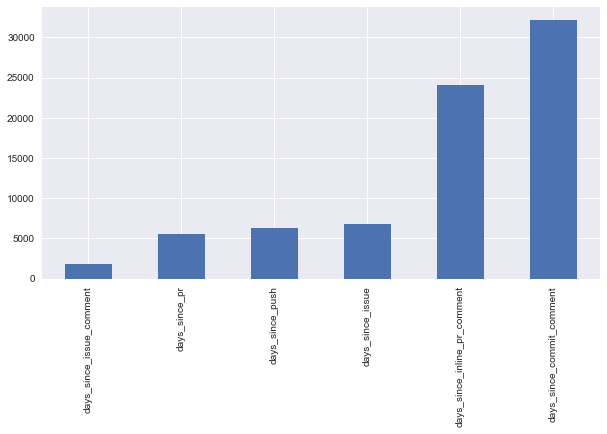

In [68]:
# Check which variables have missing values
missing = train_df.isnull().sum(); missing = missing[missing > 0]; 
missing.sort_values(inplace=True); plt.figure(figsize=(10, 5));  missing.plot.bar()

# Exclude the two predictors with so many missing values 
NUMERICAL_PREDICTORS = [x for x in NUMERICAL_PREDICTORS if x not in ["days_since_inline_pr_comment", "days_since_commit_comment"]]
DAYS_PREDICTORS = [x for x in DAYS_PREDICTORS if x not in ["days_since_inline_pr_comment", "days_since_commit_comment"]]

We see that 6 days-realted attributes have missing values, 2 of them around 50% missingness: 'days_since_inline_pr_comment' and 'days_since_commit_comment'.  Within the scope of this project, we may exclude these two from consideration.  


### 2. Outcome Variable (target_commits)

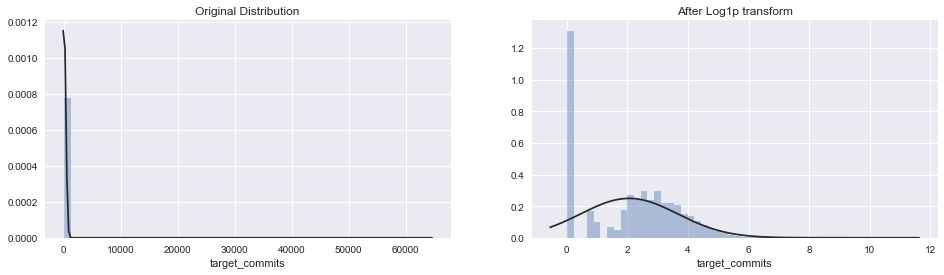

In [69]:
# Explore the Distribution of The Outcome Variable
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(1,2,1); ax1.set_title('Original Distribution')  # Original
sns.distplot(train_df['target_commits'], kde=False, fit=stats.norm)
ax2 = fig.add_subplot(1,2,2); ax2.set_title('After Log1p transform')  # Apply log(1+x) transform
sns.distplot(np.log1p(train_df['target_commits']), kde=False, fit=stats.norm)

# Apply Log(1+x) transform to target_commits 
train_df[['target_commits']] = np.log1p(train_df[['target_commits']])

It is apparent that target_commits in its original form does not follow a normal distribution at all.  After the log(1+x) transformation is applied, it looks closer to be normal distributed. In this EDA step, we tentatively assume a Gaussian Distribution to model the transformed target_commits. In the modeling phase, we will cosnider advanced solutions (e.g., mixture of Gaussian and a Bernoulli, i.e., a Zero-Inflated distribution).    

### 3. Numerical Predictors

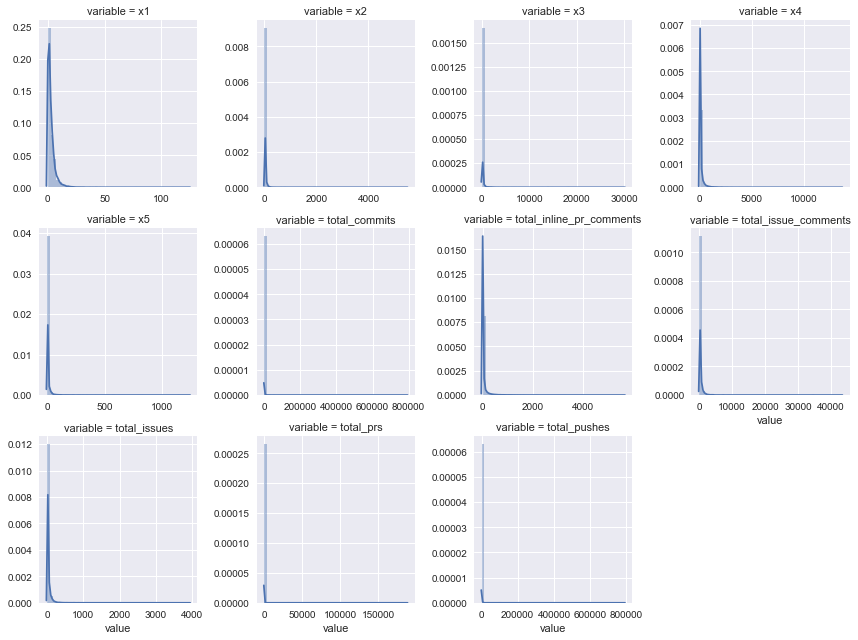

In [70]:
# Plot the histograms of the original NONDAYS_PREDICTORS 
f = pd.melt(train_df, value_vars=NONDAYS_PREDICTORS)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

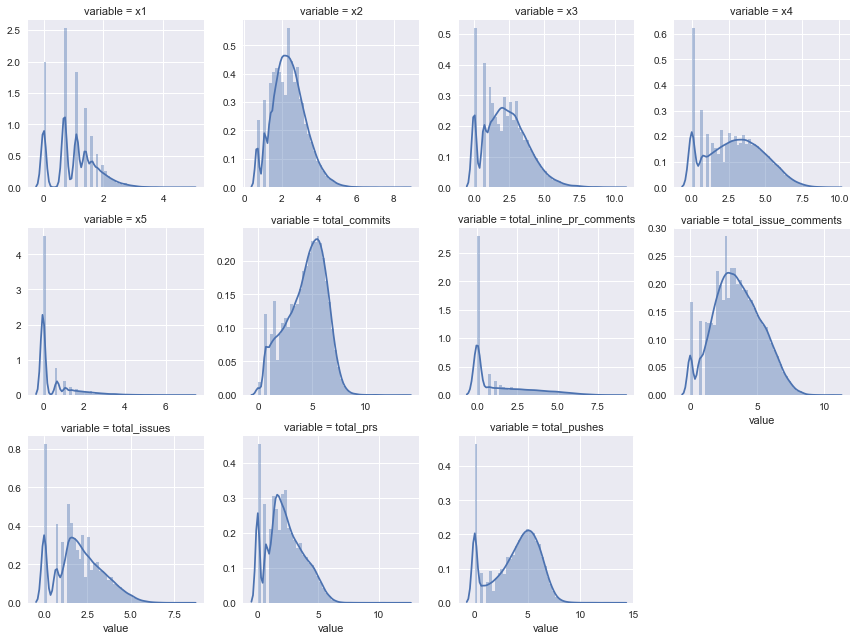

In [71]:
# Conduct log(1+x) transform to NONDAYS_PREDICTORS
train_df[NONDAYS_PREDICTORS] = train_df[NONDAYS_PREDICTORS].applymap(lambda x: np.log1p(x))
f = pd.melt(train_df, value_vars=NONDAYS_PREDICTORS)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

All Non-Days numerical predictors look like good candidates for log transformation. After the log(1+x) tansformation,  now their distributions look closer to normal distributions. But we still see some of them are zero-inflated, which suggests to create binary indicators marking inactive accounts.

In [72]:
# Derive Binary Variables to Mark Level of Activity (1 = Active; 0 = Inactive)
NONDAYS_TO_BE_TRANSFORM = ['x3', 'x4', 'x5', 'total_inline_pr_comments', 'total_issues', 'total_prs', 'total_pushes']
NONDAYS_BINARY_PREDICTORS = ["bin_" + x for x in NONDAYS_TO_BE_TRANSFORM] 
train_df[NONDAYS_BINARY_PREDICTORS] = train_df[NONDAYS_TO_BE_TRANSFORM].applymap(lambda x: 1 if x > 0 else 0)

These binary variables potentially can further interact with the above transformed continuous variables as additional new features. 

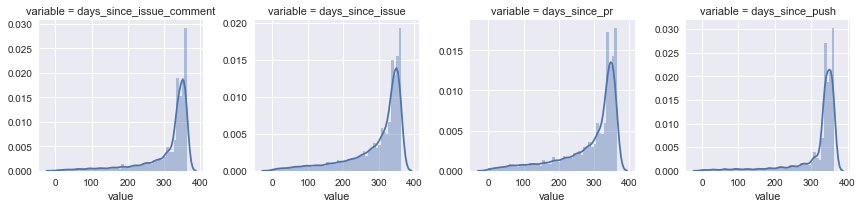

In [73]:
# Plot the histograms of the original Days-ralted Predictors 
f = pd.melt(train_df, value_vars=DAYS_PREDICTORS)
g = sns.FacetGrid(f, col="variable",  col_wrap=6, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [74]:
# Dichotomize Days-Numerical Predictors 
DAYS_BINARY_PREDICTORS = ["bin_" + x for x in DAYS_PREDICTORS] 
train_df[DAYS_BINARY_PREDICTORS] = train_df[DAYS_PREDICTORS].applymap(lambda x: 1 if x < 330 else 0)

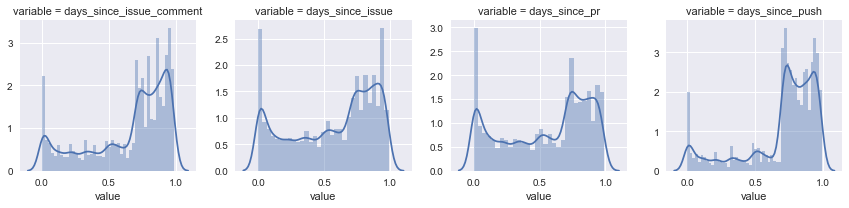

In [75]:
# Power Thansform the Days Numerical Predictors 
train_df[DAYS_PREDICTORS] = train_df[DAYS_PREDICTORS].applymap(lambda x: (x/365)**4)
f = pd.melt(train_df, value_vars=DAYS_PREDICTORS)
g = sns.FacetGrid(f, col="variable",  col_wrap=6, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

According to the definition of these days-related attributes in data_overview.pdf, higher number of a day-predictor indictes lower activity levels.  We also create new binary features using a subjectively chosen cutoff value (if a user has no activity in the past 330 days, s/he is an inactive user). 

### 4.  Text and Derived Categorical Predictors

In [76]:
# Derive new title features:  issue_title_len and pr_title_len meauring the relative length of sampled titles.
train_df[['issue_titles_len']] = np.log1p(train_df[['issue_titles']].applymap( lambda x: len(x)))
train_df[['pr_titles_len']] = np.log1p(train_df[['pr_titles']].applymap( lambda x: len(x))) 

NUMERICAL_COLUMNS += ['issue_titles_len', 'pr_titles_len']
NUMERICAL_PREDICTORS += ['issue_titles_len', 'pr_titles_len']
NONDAYS_PREDICTORS += ['issue_titles_len', 'pr_titles_len']

Due to the fact that only up to 20 sampled titles are included in the dataset, the derived length variables contain limited inforamtion.  We mainly use them to derive the binary variables below. 

In [77]:
# Dichotimize issue_titles_len and pr_titles_len (Zero vs Positive)
train_df[['bin_issue_titles_len']] = train_df[['issue_titles']].applymap( lambda x: 1 if len(x.split(", ")) > 1 else 0) 
train_df[['bin_pr_titles_len']] = train_df[['pr_titles']].applymap( lambda x: 1 if len(x.split(", ")) > 1 else 0) 

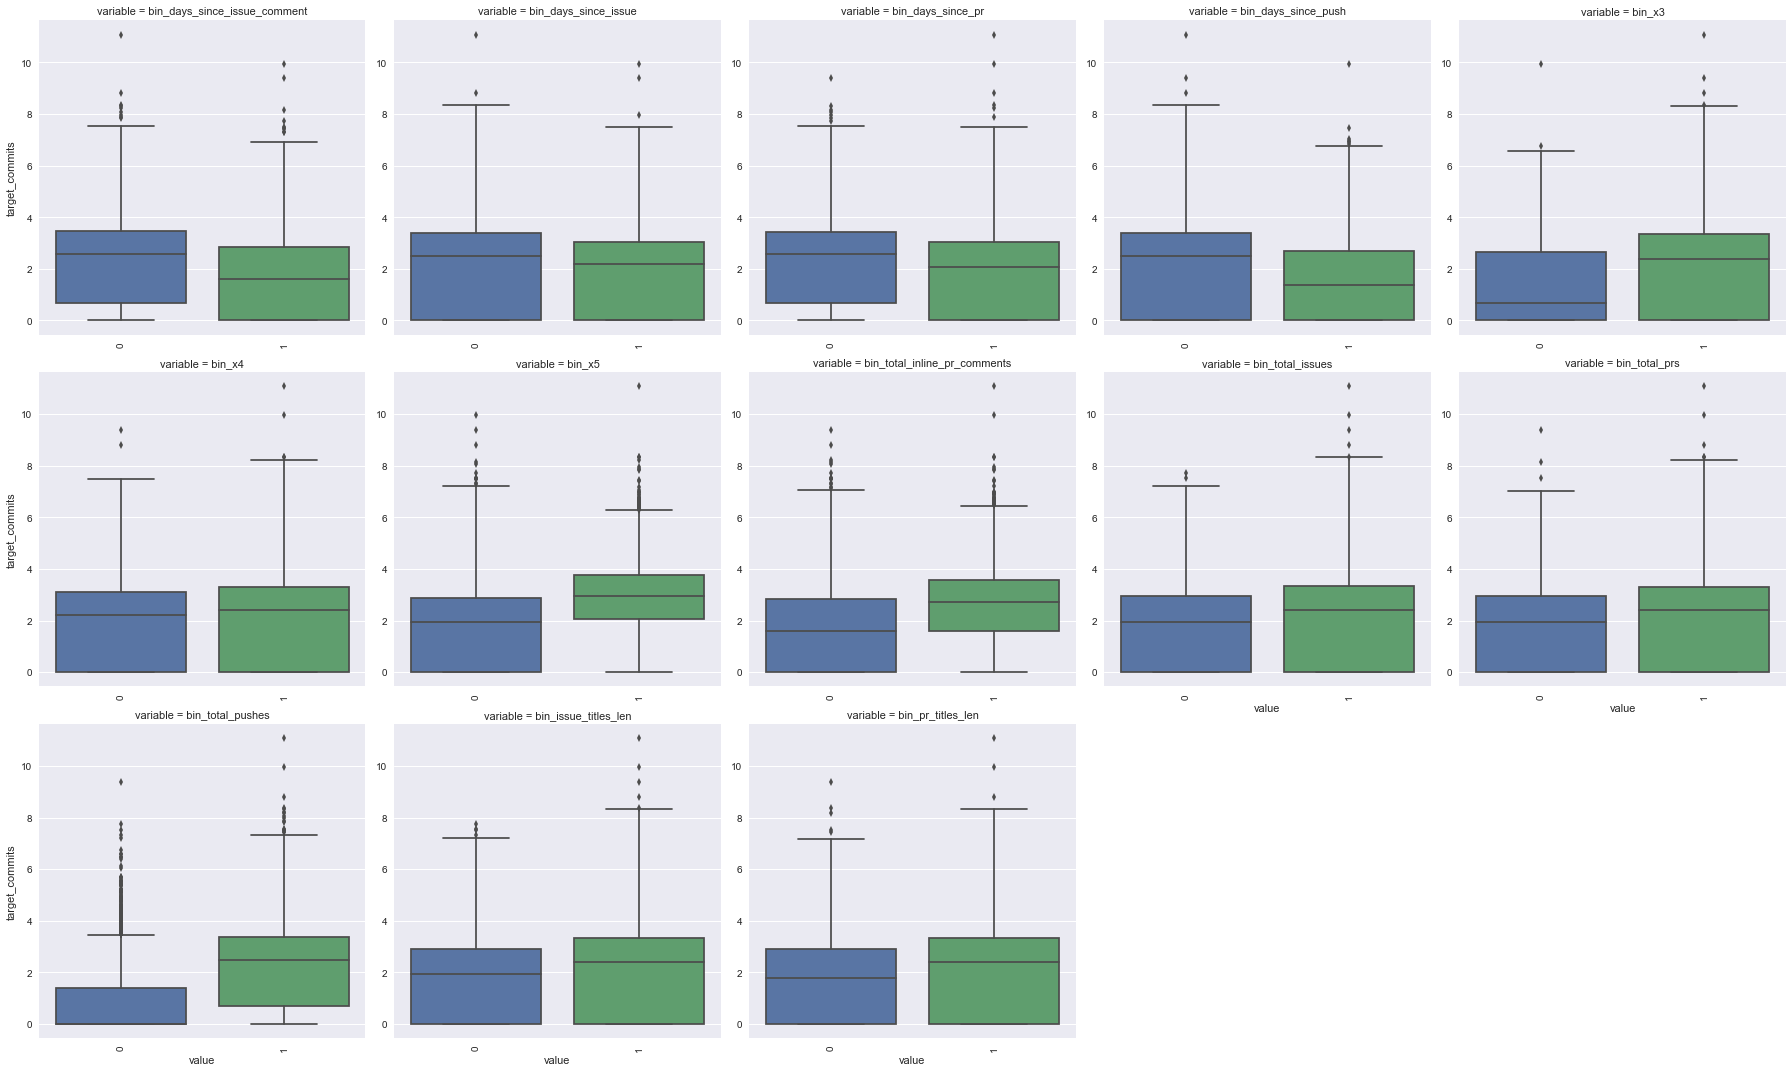

In [78]:
# Compare target_commits betweeen the two levels of the binary predictors.   

BINARY_PREDICTORS = DAYS_BINARY_PREDICTORS + NONDAYS_BINARY_PREDICTORS + ["bin_issue_titles_len", "bin_pr_titles_len"]

for c in BINARY_PREDICTORS:
    train_df[c] = train_df[c]
    if train_df[c].isnull().any():
        train_df[c] = train_df[c].cat.add_categories(['MISSING'])
        train_df[c] = train_df[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(train_df, id_vars=['target_commits'], value_vars=BINARY_PREDICTORS)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "target_commits")

We can see that target_commits has clearly different median levels between the two categories of each binary predictor. For non-day related predictors, target_commits has higher average level when the corresponding factor indicate high level of actvitiy. Nonetheless, for day-related predictors, the patterns consistently suggest that accounts with recent activities (e.g., days_since_push < 330 days) on average have lower target_commits. This worthes further investigation. 

All t-tests in comparing target_commits between the two levels of each binary predictor end with p-values smaller than 0.05.  

### 5. Correlations Between Variables

Numerical predictors that are NOT highly correlated to each other, can be candidates to be added to regression models.  Of casue, we hope they are correlated with target_commits as much as possible.  

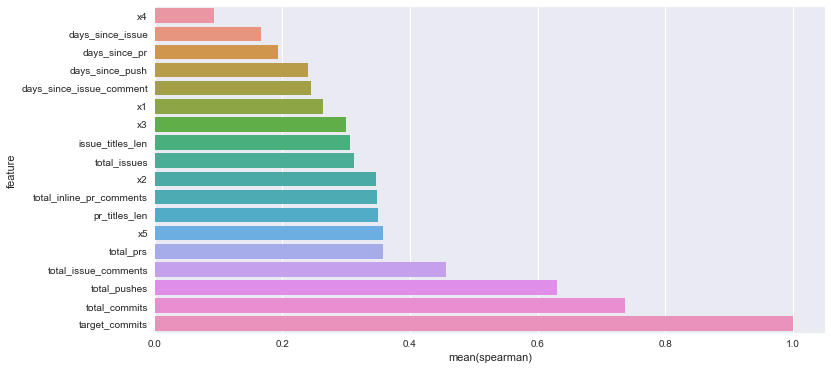

In [79]:
# Spearman correlation for each numerical predictor with target_commits
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['target_commits'], 'spearman') for f in features]
    spr = spr.sort_values('spearman'); plt.figure(figsize=(12, 6))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
spearman(train_df, NUMERICAL_PREDICTORS + OUTCOME_VARIABLE)

Spearman correlation picks up relationships between variables even when they are nonlinear.  We can see that total_commits summed for the previous year is the strongest predictor of target_commits (the #commits for the first month following the year which data were collected). Other strong predictors include total_pushes, total_issue_commits; all with correlation coefficients > 0.4.    

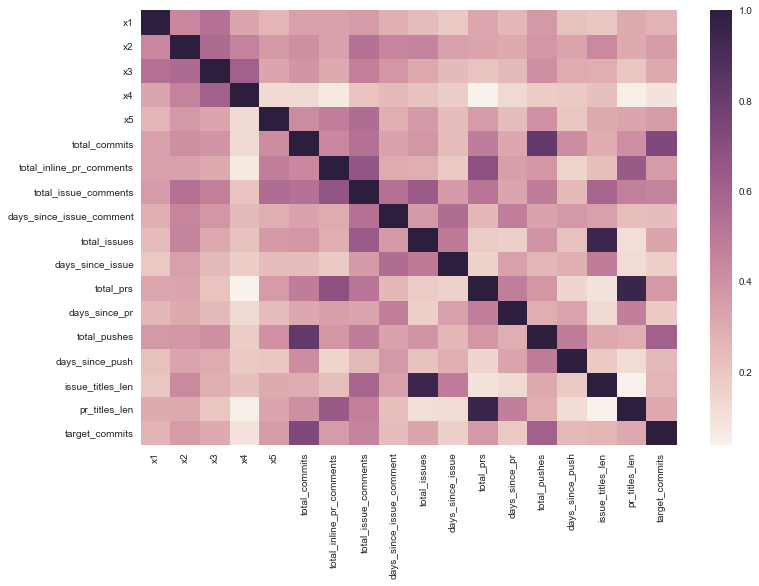

In [81]:
# Check for Collinearity 
corr = train_df[NUMERICAL_PREDICTORS + ['target_commits']].corr()
plt.figure(figsize=(12, 8)); sns.heatmap(corr); plt.show()

Although we see several pairs of numerical predictors are highly correlated: e.g., (total_issues, issue_titles_len), (total_prs, pr_title_len), this seems to be not problematic, considering that our predictive modeling would invole regularizationn or ensembling methods. Be note to the positive correaltion between 'total_commits' and 'total_pushes', which are individually correlated to 'target_commits'.   

### 6. Pairplots 

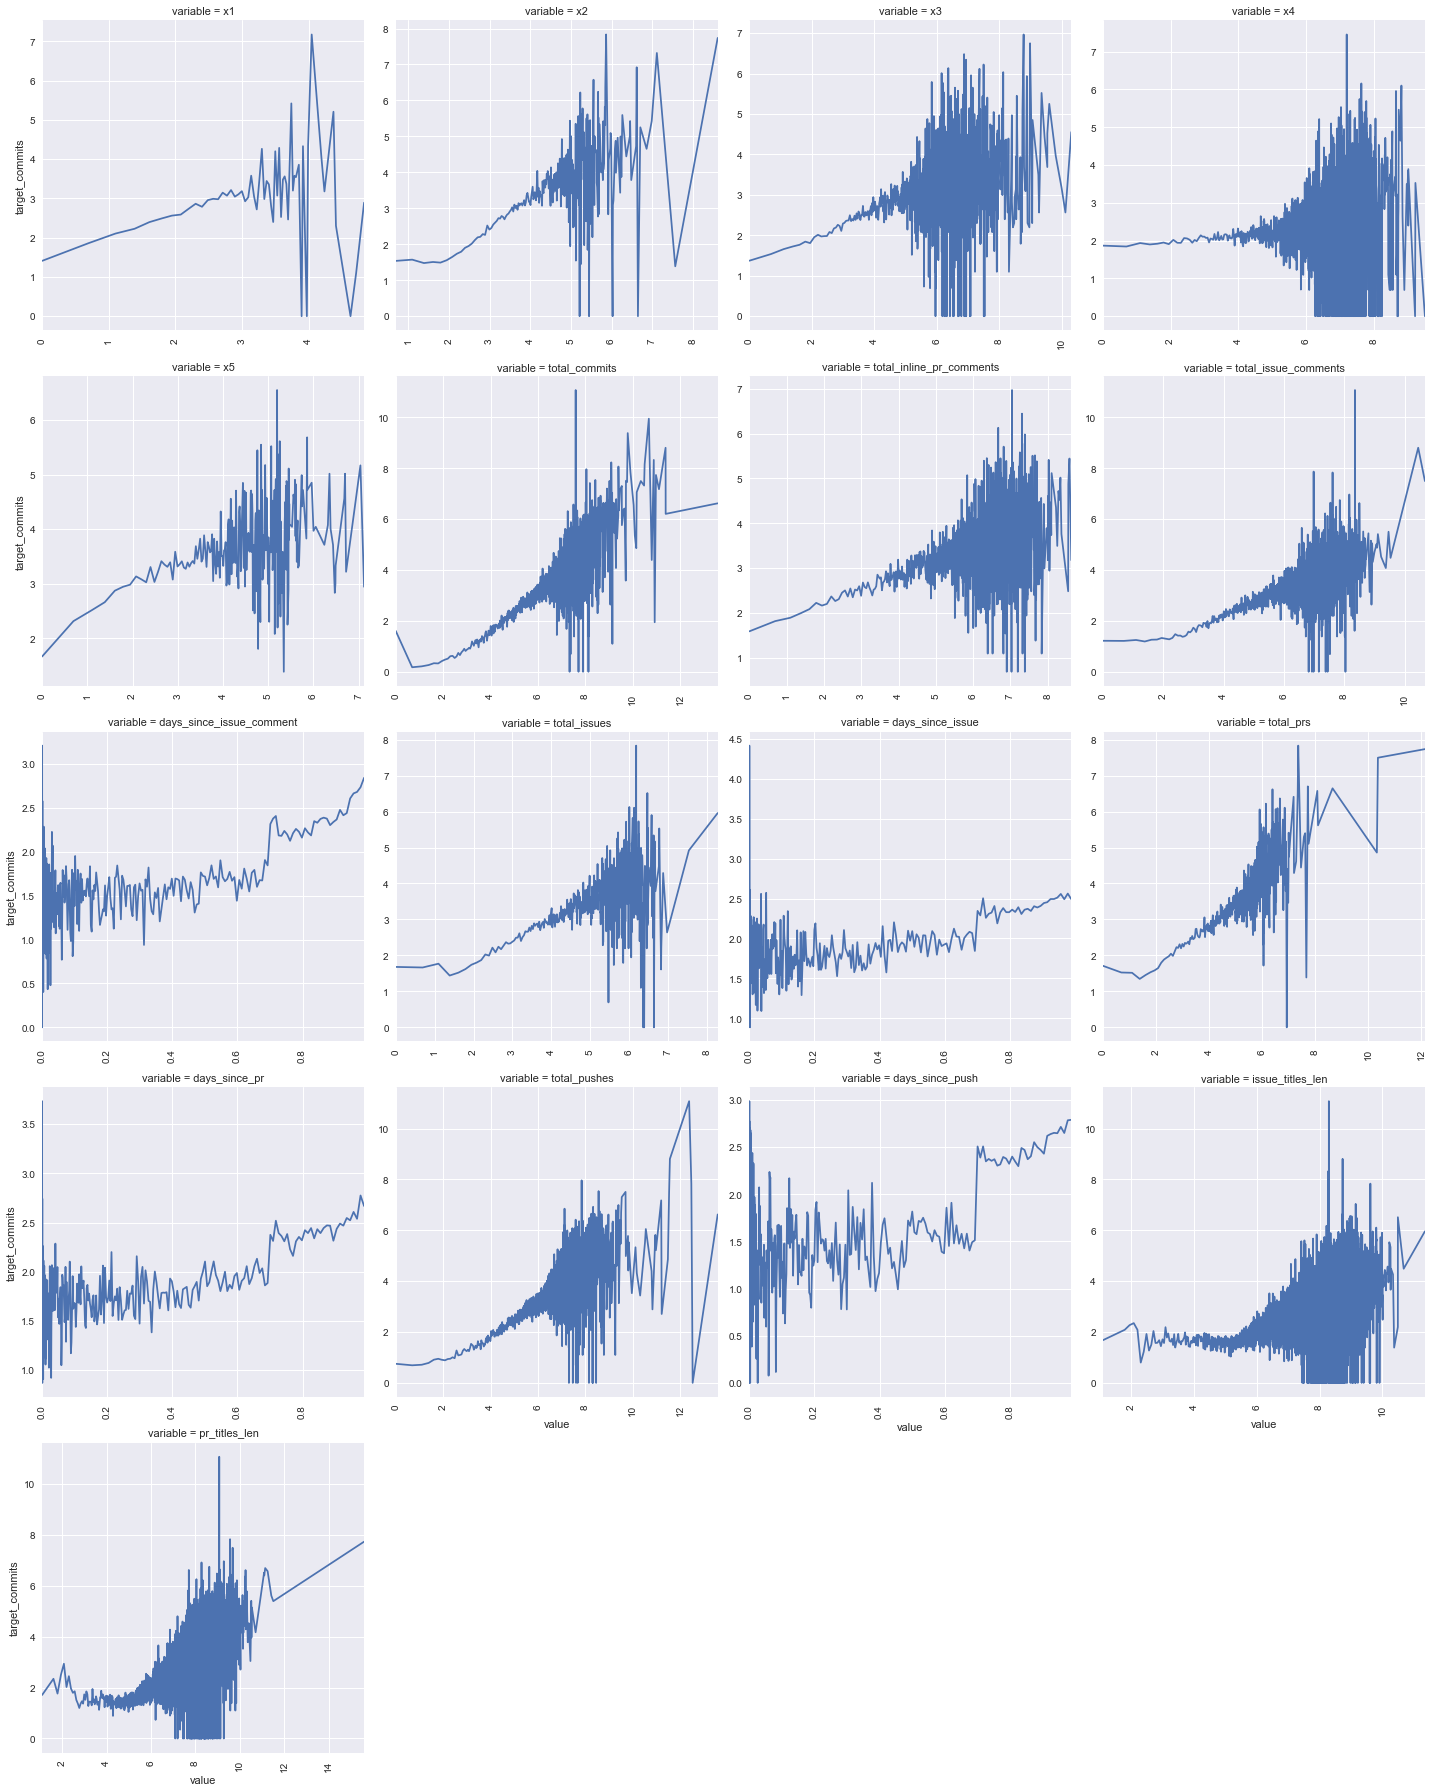

In [86]:
# Pairplots:  each describes the change of target_commits related to a predictor.

def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train_df, id_vars=['target_commits'], value_vars= NUMERICAL_PREDICTORS)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "target_commits")

For most of the predictors, we see general positive correlations between each numerical predictor and the outcome variable.  There are some evidence of nonlinearity and adding quadratic terms may be useful in regression modeling. 

In [83]:
# Create Quadratic Terms 
for feature in NONDAYS_PREDICTORS:
    train_df[feature+'_2'] = train_df[feature]**2
QUADRATIC_PREDICTORS = [x for x in train_df.columns.values.tolist() if x.endswith("_2")]

# Create Interactional Terms 
for feature in BINARY_PREDICTORS:
    train_df[feature+'_int'] = train_df[feature]*train_df[feature.replace("bin_", "")]
INTERACTION_TERMS = [x for x in train_df.columns.values.tolist() if x.endswith("_int")]

For each orignial numerical predictor, we created additonal features:  quardratice terms, and interactions terms (interaction between the numerical predictor and its corresponding binary variable).

### 7. A Baseline Model:  Linear Regression with L1 Regulariation (Lasso)

R^2: 0.56508275959
Root Mean Squared Error: 1.05101032587


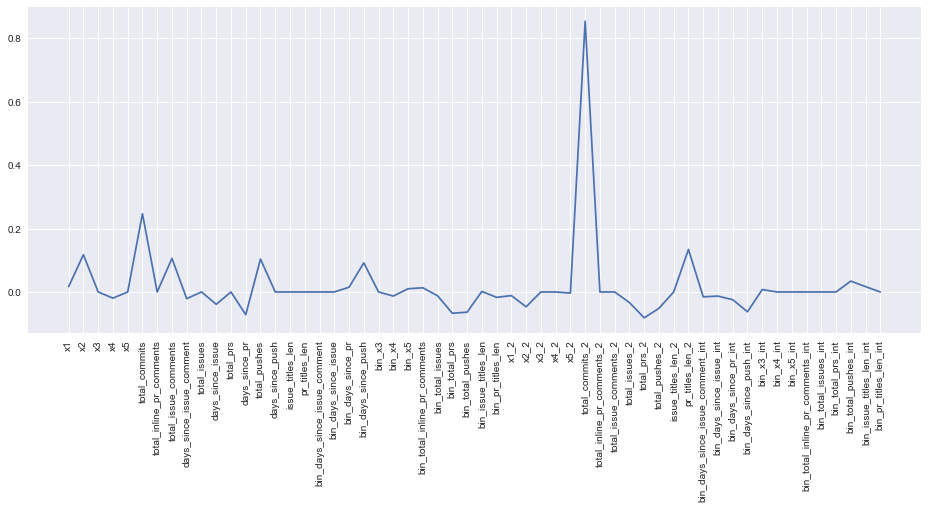

In [84]:
# Import Additional Packages Here for Regression Modeling using Lasso 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer, StandardScaler

# Put all the predictors together
features = NUMERICAL_PREDICTORS + BINARY_PREDICTORS + QUADRATIC_PREDICTORS + INTERACTION_TERMS

# Split data into Trainning and Validation (called "test" here) 
X_train, X_test, y_train, y_test = train_test_split(train_df[features],
                                                    train_df[['target_commits']],
                                                    random_state=123)

# Instantiate Pipeline object
pipe_line = Pipeline([
        ('imp' , Imputer()),
        ('scale', StandardScaler()),
        ('lasso', Lasso(alpha = 0.00001, normalize = True)) ])

# Fit the pipeline to the training data
pipe_line.fit(X_train, y_train)

# Predict on test data
y_pipeline = pipe_line.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(pipe_line.score(X_test, y_test)))
rmse = np.sqrt( mean_squared_error(y_test, y_pipeline) )
print("Root Mean Squared Error: {}".format(rmse))

# Compute and plot the regression coefficients
lasso_coef = pipe_line.named_steps['lasso'].coef_
plt.figure(figsize=(16,6))
plt.plot(range(len(features)), lasso_coef)
plt.xticks(range(len(features)), features, rotation=90);  plt.show()

Linear regression model with Lasso provides a good starting point in this project.  By applying L1 regularization, it can be used for variable selection.  As seen from the above picture, 'total_commits' and its quadratic term act as the strongest predictors.  Other notable predictors are 'X2', 'total_issue_comments', 'total_pushes', 'bin_days_since_push' ("1" if days_since_push < 330; "0" otherwise), 'pr_title_len_2' (the quadratic term of relative length of pull request titles), 'total_prs_2' (quadratic term of total_prs), and 'days_since_pr'.  

Such a model has R^2 = 0.565 with RMSE = 1.051. 

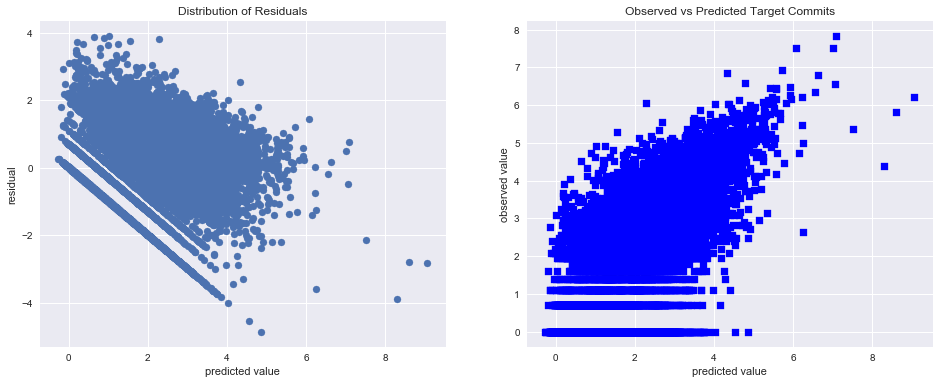

In [85]:
# let's look at the residuals as well
fig = plt.figure(figsize = (16,6))
preds = pd.DataFrame({"preds":y_pipeline, "true": y_test.target_commits})
preds["residuals"] = preds["true"] - preds["preds"]
ax1 = fig.add_subplot(1,2,1); ax1.set_title('Distribution of Residuals')
plt.xlabel('predicted value'); plt.ylabel('residual')
ax1.scatter(x = preds["preds"], y = preds["residuals"])

# See observed and predicted outcome values 
ax2 = fig.add_subplot(1,2,2); ax2.set_title('Observed vs Predicted Target Commits')
ax2.scatter(x = y_pipeline, y = y_test, c = "blue", marker = "s")
plt.xlabel('predicted value'); plt.ylabel('observed value'); plt.show()

The plot of residuals show some patterns, suggesting a negative slope as predicted value increases. The observed-vs-predicted plot clearly indicates that small observed values are predicted by higher values.  For example, a majority of inactive accounts (i.e., those with target_comments = 0) have been predicted by postive numbers.  

Such a problem reflect the departure of target_commits (after logarithmic transformation) from the Gaussian distribution due to zero-inflation. A better model have to assume a zero-inflated Gaussian distribution.  

### 8.  Check the Prediction Power of TF-IDF Features from the two Ttite Variables

In [22]:
# Load additional packages to derive TF-IDF features 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import FeatureUnion

# Obtain the text data by combining the two title variables 
get_text_data = FunctionTransformer(lambda x: x[['issue_titles','pr_titles']].apply(lambda y: " ".join(y), axis=1), 
                                    validate=False)

# Obtain the numeric data
get_numeric_data = FunctionTransformer(lambda x: x[features], validate=False)

# Split out only the text data
X_train, X_test, y_train, y_test = train_test_split(train_df[features + TEXT_PREDICTORS],
                                                    train_df['target_commits'], 
                                                    random_state=123)

# Create a FeatureUnion with nested pipeline
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer()),
                    ('scale', StandardScaler())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer( max_features=1000, stop_words='english', ngram_range=(1, 2)))
                ]))
             ]
        )

# Instantiate the Lasso model pipeline
pl_tfidf = Pipeline([
        ('union', process_and_join_features),
        ('lasso', Lasso(alpha = 0.00001, normalize = True))
    ])


# Fit to the training data
pl_tfidf.fit(X_train, y_train)

# Predict on test data
y_pl_tfidf = pl_tfidf.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(pl_tfidf.score(X_test, y_test)))
rmse = np.sqrt( mean_squared_error(y_test, y_pl_tfidf) )
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.562435447301
Root Mean Squared Error: 1.05420418798


The above analysis suggests that the TF-IDF features using bag-of-words from the contents of issue_titles and pr_titles do not contribute additional prediction power. Thus, in the rest of this project, we can feel save to ignore the text contents.   